# Algorytm Kirkpatricka

In [619]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kirkpatrick_algorithm.visualizer.main import Visualizer
from enum import Enum
import matplotlib
from scipy.spatial import Delaunay,delaunay_plot_2d
from planegeometry.structures.planarmaps import PlanarMap, Point, Segment, Triangle
from collections import deque
from typing import List
import mapbox_earcut as earcut

# Funkcje rysujące

In [3]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_point(polygon)
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [4]:
def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [5]:
def draw_polygon_colors_dict(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in polygon:
        if colors[i]==0:
            points_start.append(i)
        elif colors[i]==1:
            points_end.append(i)
        elif colors[i]==2:
            points_connect.append(i)
        elif colors[i]==3:
            points_divide.append(i)
        elif colors[i]==4:
            points_regular.append(i)

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [6]:
def draw_polygon_triangulation(polygon,tri):
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)

    for a, b in tri:
        vis.add_line_segment([polygon[a], polygon[b]], color='red')
    vis.show()

In [7]:
def draw_polygon_tri(polygon,tri):
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

# Przykładowe wielokąty

In [8]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]

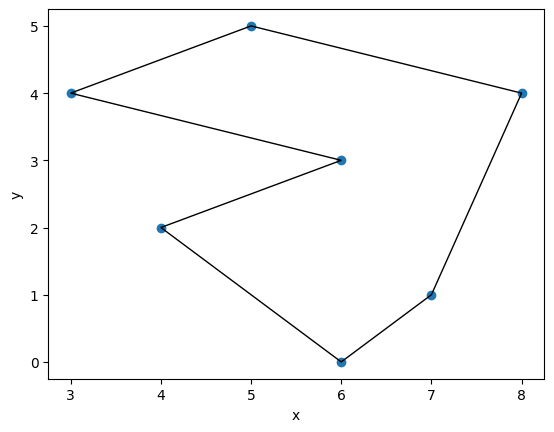

In [9]:
draw_polygon(polygon_example_1)

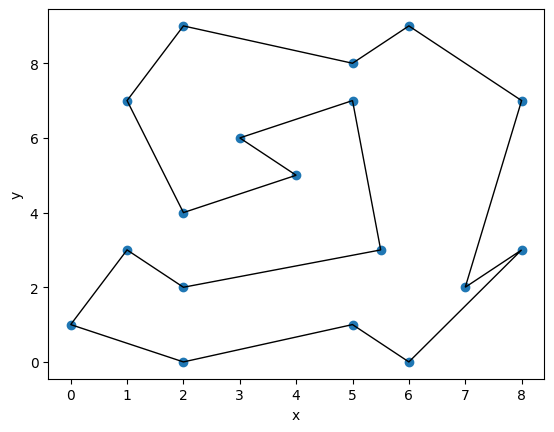

In [10]:
draw_polygon(polygon_example_2)

# Funkcja pozwalająca zadać wielokąt myszką

In [14]:
def get_polygon_points(max_x, max_y, points_data):
    %matplotlib tk
    fig = plt.figure()
    fig.set_label('Polygon Points')
    ax = fig.add_subplot(111)
    ax.set_title(f"Please select points for the polygon in counter-clockwise order")
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_y])

    cid = None

    def onclick(event):
        plt.plot(event.xdata, event.ydata, 'bo')
        points_data.append((event.xdata, event.ydata))
        ax.annotate(f"{len(points_data)}", xy=(event.xdata, event.ydata))
        fig.canvas.draw()

    def on_close(event):
        fig.canvas.mpl_disconnect(cid)
        plt.close(fig)
        %matplotlib inline
        
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    cid = fig.canvas.mpl_connect('close_event', on_close)
    plt.show()

In [15]:
polygon = []
get_polygon_points(10, 10, polygon)

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [16]:
print(polygon)

[]


# Triangulacja wielokąta

## Triangulacja Delaunaya

In [17]:
def draw_triangulation_from_triangles(polygon, triangles : Delaunay):
    vis = Visualizer()
    for a, b, c in triangles.simplices:
        vis.add_polygon([polygon[a], polygon[b], polygon[c]], fill=False, color="red")
    vis.add_polygon(polygon, fill=False, color="blue")
    return vis

In [18]:
def add_triangulation_to_vis(vis: Visualizer, polygon, triangles : Delaunay):
    for a, b, c in triangles.simplices:
        vis.add_polygon([polygon[a], polygon[b], polygon[c]], fill=False)

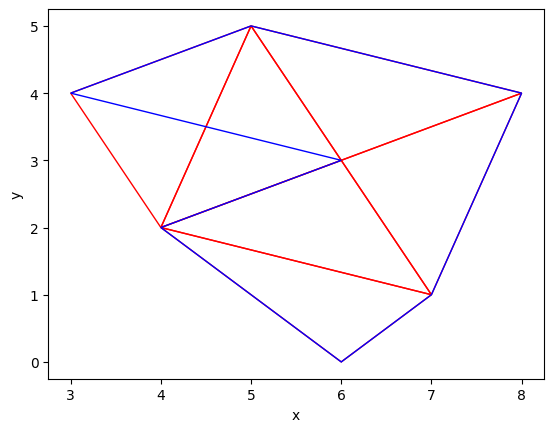

In [19]:
triangulation_example_1 = Delaunay(polygon_example_1)
tri_vis_1 = draw_triangulation_from_triangles(polygon_example_1, triangulation_example_1)
tri_vis_1.show()

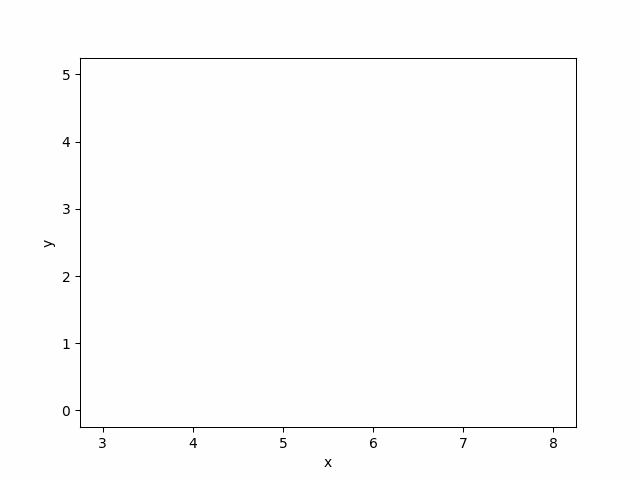

In [20]:
tri_vis_1.show_gif()

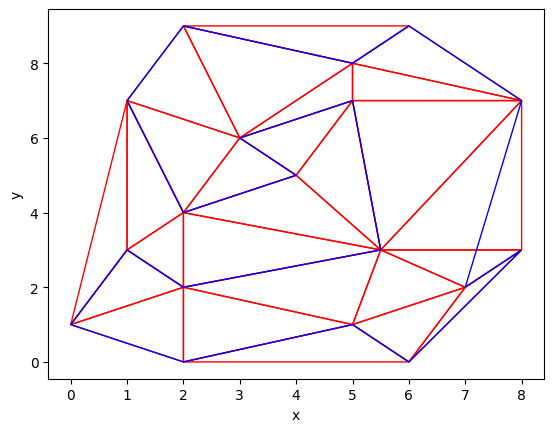

In [21]:
triangulation_example_2 = Delaunay(polygon_example_2)
tri_vis_2 = draw_triangulation_from_triangles(polygon_example_2, triangulation_example_2)
tri_vis_2.show()

## Dodawanie trójkąta zewnętrznego

In [504]:
def add_outer_triangle(polygon):
    min_x = min(polygon, key=lambda p: p[0])[0]
    max_x = max(polygon, key=lambda p: p[0])[0]
    min_y = min(polygon, key=lambda p: p[1])[1]
    max_y = max(polygon, key=lambda p: p[1])[1]

    a = (max_x - min_x)
    b = (max_y - min_y)

    min_x -= a*0.2
    max_x += a*0.2
    min_y -= b*0.2
    max_y += b*0.2

    sqrt_d = np.sqrt(4*a*a - 4*(a*a - 4/3*b*b))

    d = (2*a + sqrt_d)/2

    shift = (d - a)/2
    H = d*np.sqrt(3)/2

    return [(max_x + shift, min_y),(min_x - shift, min_y), ((max_x - min_x)/2 + min_x, H)]


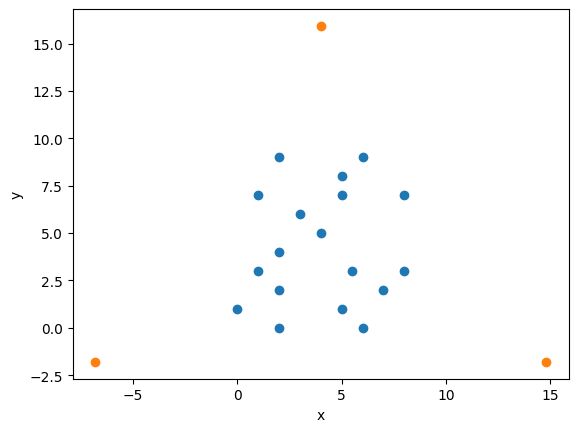

In [505]:
outer_triangle = add_outer_triangle(polygon_example_2)
vis = Visualizer()
vis.add_point(polygon_example_2)
vis.add_point(outer_triangle)
vis.show()

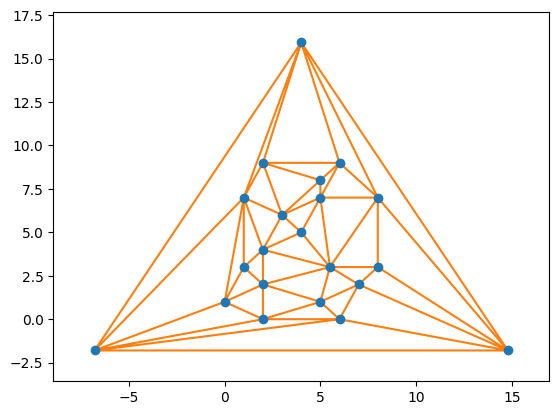

In [506]:
ex2_with_outer = polygon_example_2 + outer_triangle
tri_ex2 = Delaunay(ex2_with_outer)
_ = delaunay_plot_2d(tri_ex2)

In [507]:
outer_triangle=set([Point(x, y) for x, y in outer_triangle])

# Konwersja polygonu do formatu podwójnie łączonej listy krawędzi

In [533]:
def get_planar_map(delaunay: Delaunay) -> PlanarMap:
    points = [Point(p[0], p[1]) for p in delaunay.points]
    triangles = [Triangle(points[a], points[b], points[c]) for a, b, c in delaunay.simplices]
    dcel_map = PlanarMap(triangles[0])

    visited = [False]*len(delaunay.simplices)
    queue = deque(delaunay.neighbors[0])
    
    visited[0] = True

    while queue:
        simplex = queue.popleft()
        if simplex == -1:
            continue 
        
        visited[simplex] = True

        temp_map = PlanarMap(triangles[simplex])
        dcel_map = dcel_map.map_overlay(temp_map)

        for v in delaunay.neighbors[simplex]:
            if v != -1 and not visited[v]:
                queue.append(v)
                visited[simplex] = True
        
    return dcel_map

In [690]:
planar_map = get_planar_map(tri_ex2)

In [535]:
def get_independent_set(planar_map: PlanarMap, outer_triangle):
    visited = set()
    independent_set = []

    for point in planar_map.iterpoints():
        if point not in visited and point not in outer_triangle:
            independent_set.append(point)
            
            for adjacent_point in planar_map.iteradjacent(point):
                visited.add(adjacent_point)

    return independent_set

In [691]:
indepndent_set = get_independent_set(planar_map, outer_triangle)

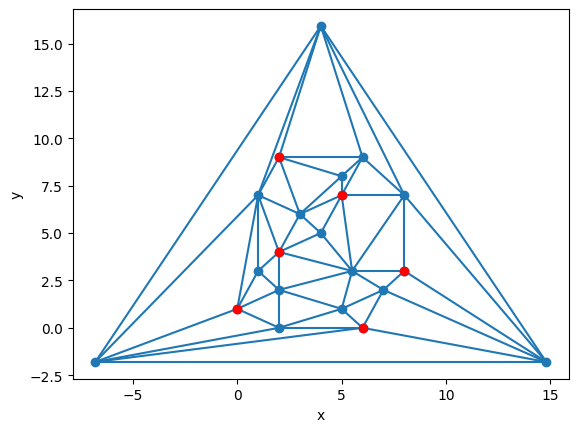

In [537]:
vis = Visualizer()
vis.add_line_segment([((segment.source.x, segment.source.y), (segment.target.x, segment.target.y)) for segment in planar_map.iteredges()])
vis.add_point([(point.x, point.y) for point in planar_map.iterpoints()])
vis.add_point([(point.x, point.y) for point in indepndent_set], color="red", zorder=10)
vis.show()

In [689]:
def remove_independent_set(planar_map: PlanarMap, indepndent_set, outer_triangle):
    holes = []
    deleted_nodes = 0

    for independent_point in indepndent_set:
        if independent_point not in outer_triangle:

            outedges = sorted(list(planar_map.iteroutedges(independent_point)), key=lambda e: (e.target - e.source).alpha())
            holes.append([outedge.target for outedge in outedges])
            planar_map.del_node(independent_point)
            deleted_nodes += 1

    return holes, deleted_nodes 

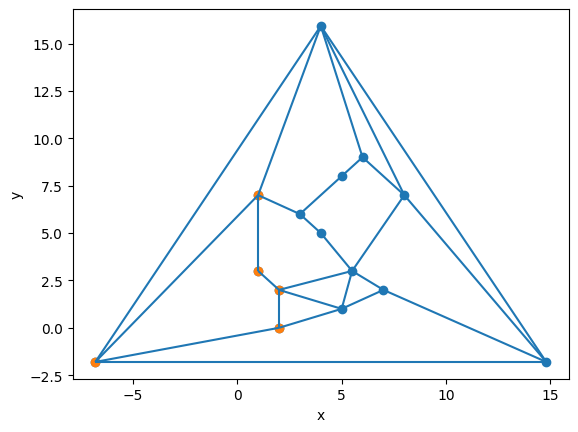

In [692]:
holes, deleted_points = remove_independent_set(planar_map, indepndent_set, outer_triangle)
vis.clear()
vis.add_line_segment([((segment.source.x, segment.source.y), (segment.target.x, segment.target.y)) for segment in planar_map.iteredges()])
vis.add_point([(point.x, point.y) for point in planar_map.iterpoints()])
vis.add_point([(point.x, point.y) for point in holes[0]])
vis.show()

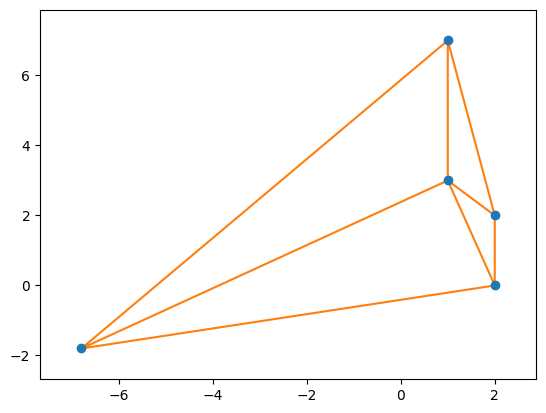

In [541]:
new_tri = Delaunay([(point.x, point.y) for point in holes[0]])
_ = delaunay_plot_2d(new_tri)

# Preprocessing Algorytmu Kirkpatricka

In [693]:
def draw_planar_map(planar_map: PlanarMap, indepndent_set):
    vis = Visualizer()
    vis.add_line_segment([((segment.source.x, segment.source.y), (segment.target.x, segment.target.y)) for segment in planar_map.iteredges()])
    vis.add_point([(point.x, point.y) for point in planar_map.iterpoints()])
    vis.add_point([(point.x, point.y) for point in indepndent_set], color="red", zorder=10)
    vis.show()

In [696]:
def kirkpatrick_preprocess(polygon: List[tuple[float, float]]):
    outer_triangle = add_outer_triangle(polygon)
    polygon_with_outer_triangle = polygon + outer_triangle

    delaunay_triangulation = Delaunay(polygon_with_outer_triangle)
    outer_triangle = set([Point(x, y) for x, y in outer_triangle])

    planar_map = get_planar_map(delaunay_triangulation)

    v = len(polygon_with_outer_triangle)

    while v > 3:
        independent_set = get_independent_set(planar_map, outer_triangle)
        draw_planar_map(planar_map, independent_set)
        holes_points, removed = remove_independent_set(planar_map, independent_set, outer_triangle)
        draw_planar_map(planar_map, independent_set)

        v -= removed

        for hole_points in holes_points:
            
            verts = np.array([[point.x, point.y] for point in hole_points]).reshape(-1, 2)
            rings = np.array([len(verts)])
            result = earcut.triangulate_float32(verts, rings)

            for a, b, c in result.reshape(-1,3):
                segments_to_add =  [(Segment(hole_points[a], hole_points[b])), 
                                    (Segment(hole_points[a], hole_points[c])), 
                                    (Segment(hole_points[b], hole_points[c]))]
            
                for segment in segments_to_add:
                    if not planar_map.has_edge(segment):
                        planar_map.add_edge(segment)
            
        draw_planar_map(planar_map, [])


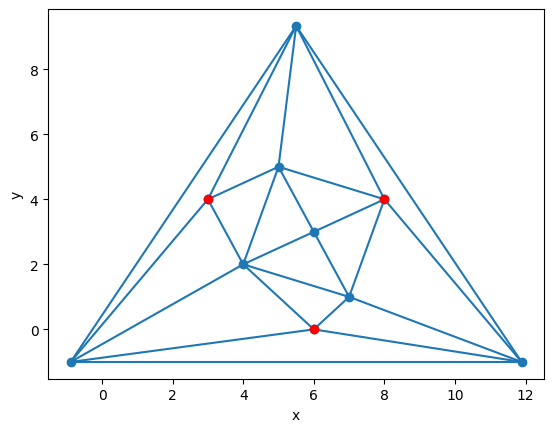

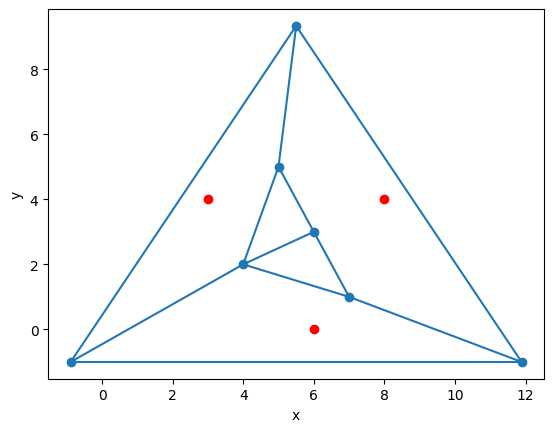

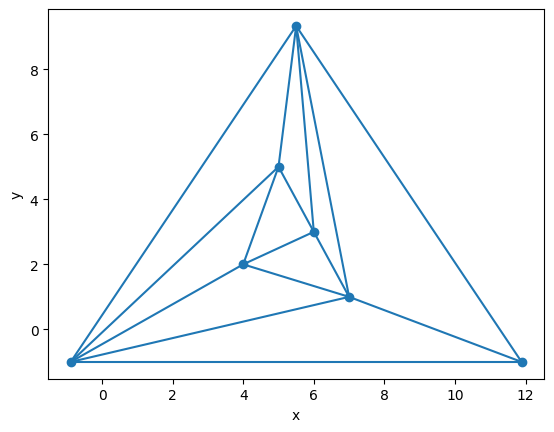

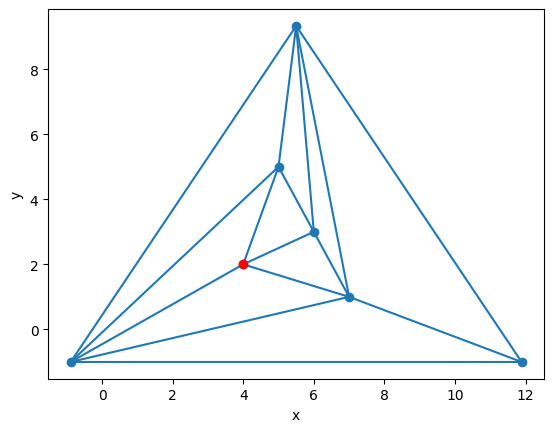

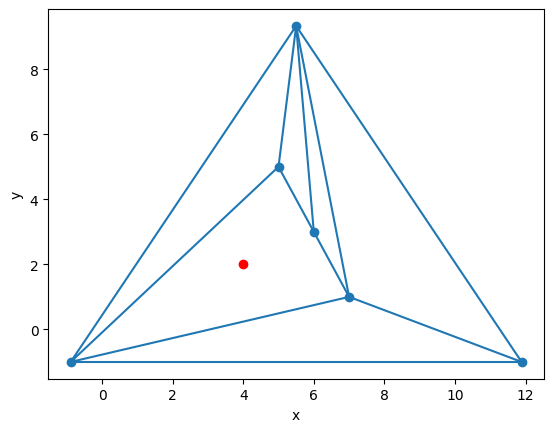

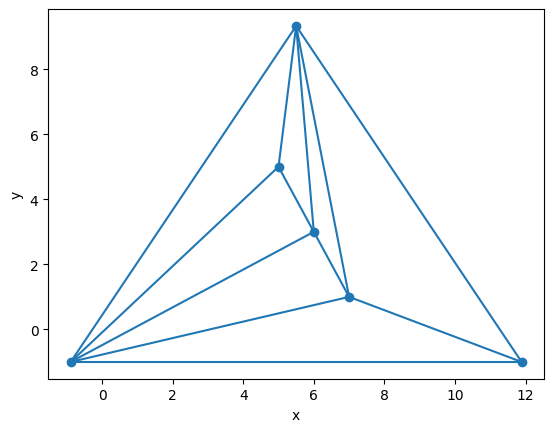

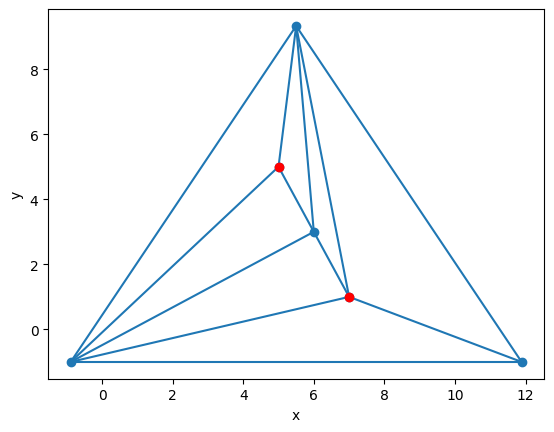

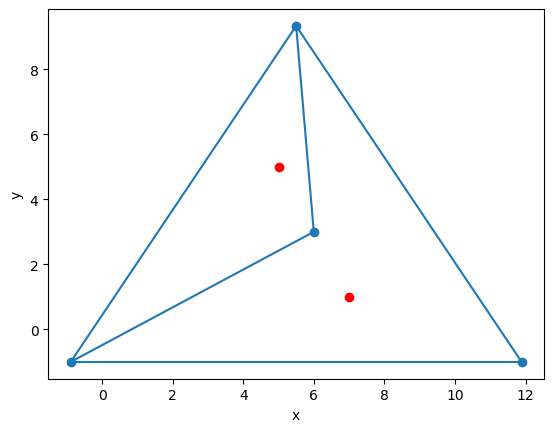

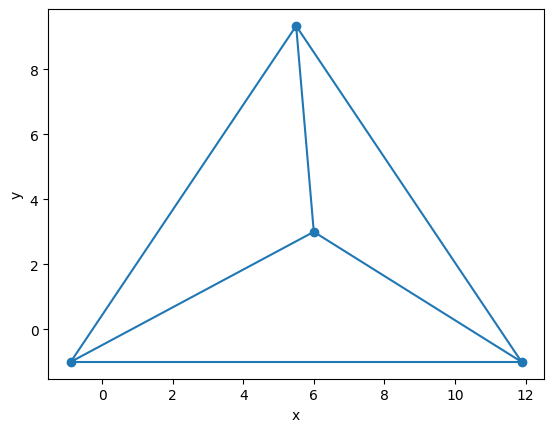

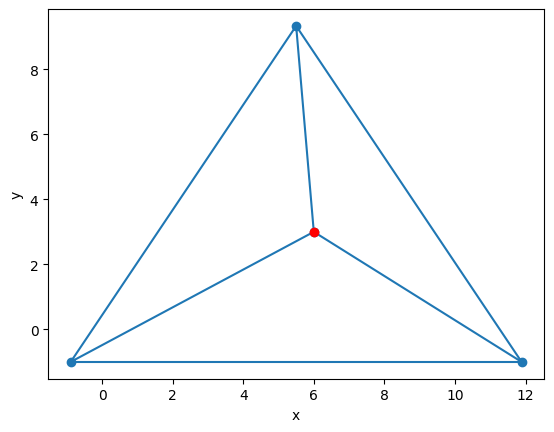

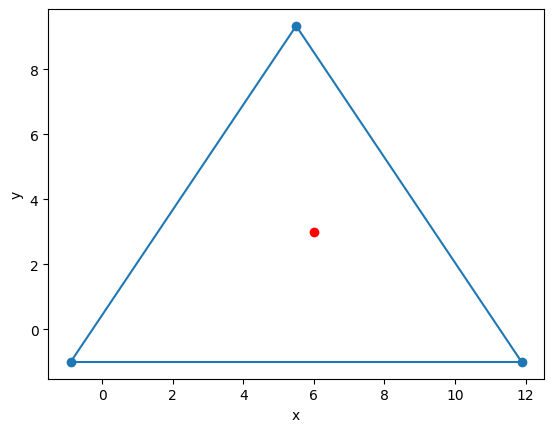

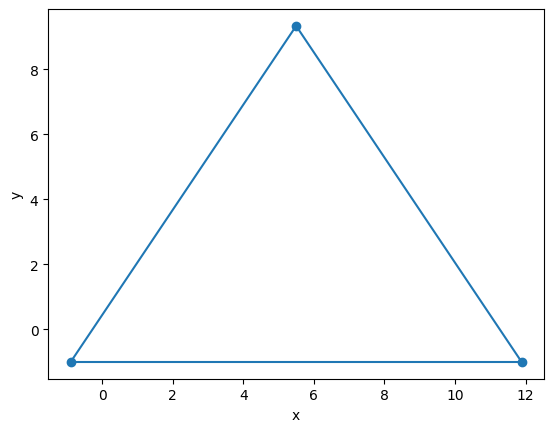

In [698]:
kirkpatrick_preprocess(polygon_example_1)